# Google drive setup
* Uses a google account's google drive to store dataset
* prerequisites : a folder named "AI" in the root directory of drive which will be used for dataset.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir("drive/My Drive/AI")

Mounted at /content/drive


# Loading the dataset - 
* Downloads the face mask dataset to your drive and unzips it using drive REST Api.
* Loads the images and its labels to a pandas dataframe
* Save the dataframe as a  pickle file, which can be subsequently used training the model.
* ref : https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

In [ ]:
"""
Preparing the pickle
"""

from pathlib import Path

import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive
from tqdm import tqdm
from pathlib import Path
import shutil


dirpath = Path('data/dataset')
# cleaing tree
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)

os.makedirs('data/dataset')
datasetPath = Path('data/dataset/dataset.zip')
gdd.download_file_from_google_drive(file_id='1UDvUL7nuzt3JStnN1KOl_onC5h7q6H9O',dest_path=str(datasetPath),unzip=True)

# https://drive.google.com/file/d/1UDvUL7nuzt3JStnN1KOl_onC5h7q6H9O/view?usp=sharing
# Id for hosted file : 1UDvUL7nuzt3JStnN1KOl_onC5h7q6H9O

datasetPath.unlink()
datasetPath = Path('data/dataset')
clothMaskPath = datasetPath/'with_cloth_mask'
surgicalMaskPath = datasetPath/'with_surgical_mask'
ffp2MaskPath = datasetPath/'with_ffp2_mask'
nonMaskPath = datasetPath/'without_mask'

maskDF = pd.DataFrame()
for imgPath in tqdm(list(nonMaskPath.iterdir()), desc='without_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)

for imgPath in tqdm(list(surgicalMaskPath.iterdir()), desc='with_surgical_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)

for imgPath in tqdm(list(clothMaskPath.iterdir()), desc='with_cloth_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)

for imgPath in tqdm(list(ffp2MaskPath.iterdir()), desc='with_ffp2_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 3
    }, ignore_index=True)

print(maskDF)

dfName = 'data/dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)

Unzipping...Done.


with_ffp2_mask: 100%|██████████| 486/486 [00:01<00:00, 338.29it/s]

                                                  image  mask
0          data/dataset/without_mask/without_mask_1.jpg   0.0
1         data/dataset/without_mask/without_mask_10.jpg   0.0
2        data/dataset/without_mask/without_mask_100.jpg   0.0
3        data/dataset/without_mask/without_mask_101.jpg   0.0
4        data/dataset/without_mask/without_mask_102.jpg   0.0
...                                                 ...   ...
2347  data/dataset/with_ffp2_mask/with_ffp2_mask (97...   3.0
2348  data/dataset/with_ffp2_mask/with_ffp2_mask (98...   3.0
2349  data/dataset/with_ffp2_mask/with_ffp2_mask (98...   3.0
2350  data/dataset/with_ffp2_mask/with_ffp2_mask (99...   3.0
2351  data/dataset/with_ffp2_mask/with_ffp2_mask (99...   3.0

[2352 rows x 2 columns]
Saving Dataframe to: data/dataset/dataset.pickle


# Custom dataset class
* Loads the dataset as PIL
* Resizes images to 32x32
* Convert image to tensor -https://discuss.pytorch.org/t/pytorch-pil-to-tensor-and-vice-versa/6312
* Normalizes images to have values in the range of 0-1

In [ ]:
"""
The DataSet class
"""

from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize


class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.225, 0.225, 0.225]
                )
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

# CNN model for face mask detection
* The model takes 3 channels(R,G,B) as input
* The model gives an output of one of 4 classes 
* 0 -> without_mask, 1 -> 'with_mask_surgical', 2 -> 'with_mask_cloth', 3 -> 'with_mask_ffp2'

In [ ]:
"""
The CNN model
"""

import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU, Sequential, functional)

class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()
        # Conv Layers : Conv2d
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) # 32 - 3 + 1 + 2*1 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1) # 32 - 3 + 1 + 2*1
        #fully Connected: Linear :: features
        # torch.nn.Linear(in_features, out_features, bias=True)
        # in_features – size of each input sample
        # out_features – size of each output sample
        batch_size = 3
        # Simulate a 32 x 32 pixel, rgb "image"
        ip = torch.randn(3, 32, 32)
        print(ip.view(batch_size, -1).size())
        self.fc1 = nn.Linear(8 * 8 * 8, 32)  # 8(out_channel :: prev) &&  8 * 8(computation from the forward max_pool2d * 2 with stride 2) 
        self.fc2 = nn.Linear(32, 4) # final feature labels as 4
    
    def forward(self, x: Tensor):
        """ forward pass 
        The forward() method is the actual network transformation. 
        The forward method is the mapping that maps an input tensor 
        to a prediction output tensor.
        # Convolution Operation
        """
        out = functional.max_pool2d(torch.tanh(self.conv1(x)), 2) # 32 -> 16
        out = functional.relu(out)
        out = functional.max_pool2d(torch.tanh(self.conv2(out)), 2) # 16 -> 8
        out = functional.relu(out)
        # flatten
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        # fc layer
        out = self.fc2(out)
        return out

face_mask_detector_cnn = FaceMaskDetectorCNN()
print(face_mask_detector_cnn

torch.Size([3, 1024])
FaceMaskDetectorCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)


# Summary of Layers

In [ ]:
"""
Print model summary
"""

from torchsummary import summary
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2            [-1, 8, 16, 16]           1,160
            Linear-3                   [-1, 32]          16,416
            Linear-4                    [-1, 4]             132
Total params: 18,156
Trainable params: 18,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.22
----------------------------------------------------------------
None


# Split validation data
* Loads the pickle file that was saved previously
* Splits dataset into 70/30 split for test,validate
* Create a DataLoader helper function for automatic batching

In [ ]:
"""
Some utilities
"""

from pathlib import Path
from typing import Dict, List, Union

import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU, Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt

def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        # print the distribution
        print(mask_df['mask'].value_counts())
        train, validate = train_test_split(mask_df, test_size=0.3, random_state=0,
                                           stratify=mask_df['mask'])
        return [
            MaskDetectionDataset(train),
            MaskDetectionDataset(validate),
            CrossEntropyLoss()
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=4)   

train_df, validate_df, cross_entropy_loss = prepare_data("data/dataset/dataset.pickle")

0.0    857
2.0    507
1.0    502
3.0    486
Name: mask, dtype: int64


# Training the model
* For each batch get the images and its labels
* Pass it to the model to get predictions
* compare losses with actual, predicted values

In [ ]:
epochs = 20 
learning_rate = 0.001 
retrain = False
"""
Training Step
"""

import warnings
warnings.filterwarnings('ignore')

def train_model():
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_df), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_train += loss
        print(f' LOSS :: Training Loss (after epoch {epoch}):', loss_train)

train_model()
print('Model training has finished')

 LOSS :: Training Loss (after epoch 0): tensor(59.8988, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 1): tensor(41.9353, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 2): tensor(34.3393, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 3): tensor(32.3088, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 4): tensor(29.7826, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 5): tensor(26.8971, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 6): tensor(26.0063, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 7): tensor(24.4546, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 8): tensor(22.7883, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 9): tensor(22.0907, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 10): tensor(20.8329, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 11): tensor(19.8664, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 12

# Evaluate the model 
* Run the model to evaluate its accuracy on unseen images using validate dataset
* print model's accuracy, f1, precision, recall scores

tensor([[ 4.9749, -2.9268,  1.4400, -1.8872],
        [ 6.7191, -2.3491, -1.1010, -2.5142],
        [ 4.9942, -2.2294, -0.1722, -1.5820],
        [-0.3935, -2.2706,  4.8310,  0.1497],
        [ 4.4671, -0.4402, -2.1234, -1.9519],
        [-4.9776,  5.1564, -1.3237,  0.5769],
        [-4.2076,  3.7075, -1.6370,  1.4997],
        [-3.6920,  2.6417,  0.0421,  1.5486],
        [ 3.3713, -2.1996,  0.8404, -1.2213],
        [-3.1584,  3.8606, -1.9441,  0.3578],
        [-4.0523,  4.4572, -1.2218,  0.7005],
        [-3.4448,  4.6320, -1.1305, -0.1908],
        [-3.0180, -2.0527,  0.1524,  5.8770],
        [ 3.8786, -1.3600,  0.6406, -2.5939],
        [ 4.8380, -1.2151, -1.2053, -1.8186],
        [ 4.4697, -1.7069, -0.5202, -1.1238],
        [ 3.9451, -1.4851,  0.4048, -1.4441],
        [-2.4694,  1.2170,  2.4536, -0.0622],
        [-3.2928, -0.8866, -0.7465,  5.4053],
        [-4.4536,  0.4471, -1.1621,  5.4465],
        [ 6.1652, -2.7786,  0.3561, -2.2877],
        [-4.1390, -0.0920, -0.3439

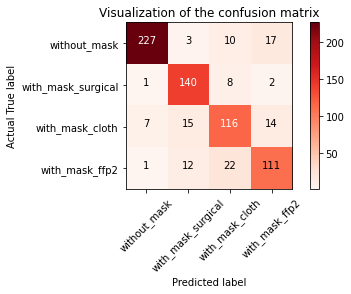

In [ ]:
"""
Evaluate the model
"""

from numpy import vstack
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

def evaluate_model():
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_df)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)  
        
    #print metrics
    classes = ['without_mask','with_mask_surgical', 'with_mask_cloth', 'with_mask_ffp2']
    print(classification_report(actuals, predictions, digits = 4, target_names=classes))
    confusion_mat = confusion_matrix(actuals.numpy(), predictions.numpy())
    plot_cm(confusion_mat, classes)
evaluate_model()

# Prediction of random image using trained Model

tensor([[ 6.1652, -2.7786,  0.3561, -2.2877],
        [ 2.8030, -1.0855, -0.7794, -0.2266],
        [-0.4929, -1.1196,  1.7741,  1.7962],
        [-3.1879, -0.6905, -0.0110,  4.7412],
        [-1.1976,  2.1018, -0.1343, -1.2656],
        [-0.4021,  0.4931,  0.0560,  1.0267],
        [-4.9194,  5.2465, -0.6478, -0.2183],
        [-0.9087,  2.3897,  1.4185, -3.4418],
        [ 6.0978, -1.7871, -1.8143, -1.9952],
        [-4.0854,  3.5995, -0.4853,  1.4663],
        [ 3.9451, -1.4851,  0.4048, -1.4441],
        [ 5.1181, -1.2919, -2.5584, -1.1509],
        [-3.1710,  1.7720,  2.4703, -0.8640],
        [ 2.1724, -0.7867, -1.2877, -0.1074],
        [ 3.1674, -1.1016, -1.4224,  0.1817],
        [-2.9866,  2.5881,  1.8340, -1.7629],
        [ 2.3187,  0.7703, -1.3419, -0.6822],
        [ 4.4500, -1.4424, -1.2288, -1.1965],
        [-1.2066,  1.9295,  0.9960, -0.6091],
        [-3.8752,  4.5744, -1.3439,  0.4718],
        [-2.0223, -1.2566, -1.1818,  4.0588],
        [-3.2312, -0.1127, -2.6334

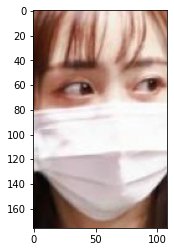

In [ ]:
"""
Predict
"""

import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "with_mask_surgical",
    2: "with_mask_cloth",
    3: "with_mask_ffp2",
}

def predict():
  rand_sampler = torch.utils.data.RandomSampler(validate_df, num_samples=32, replacement=True)
  data = iter(DataLoader(validate_df, batch_size=32, num_workers=1, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  print(data['path'][rand_ind])
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()